# Access AWS CESM2 using the AWS open data origin data 

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
# import seaborn as sns
import re
# import nest_asyncio
# nest_asyncio.apply()
import aiohttp

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [5]:
# This overwrites the default scheduler with a single-threaded scheduler
dask.config.set(scheduler='synchronous')  

In [6]:
# File paths
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
#
rda_data           = '/gpfs/csfs1/collections/rda/data/'
new_intake_path    = rda_data + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'
new_intake_csvpath = rda_data + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.csv'

### Set up osdf url to use with PelicanFS
- We should one of the two pelicanFS FSSpec protocols ('osdf' or 'pelican') instead of the https protocol.
- We will use the 'osdf' protocol and modify the existing CESM2-LENS catalog
- So, the urls will look like: osdf_discovery_url + namespace prefix + path to file or object
- In this case, the urls will look like osdf:///aws-opendata/us-west-2/ncar-cesm2-lens + path to individual zarr stores

In [7]:
s3_link  = 's3://'
# osdf_url = 'https://osdf-director.osg-htc.org/aws-opendata/us-west-2/'
osdf_url = 'osdf:///aws-opendata/us-west-2/'
#
rda_url        =  'https://data.rda.ucar.edu/'
new_intake_url = rda_url + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'

In [13]:
%%time
pelfs = OSDFFileSystem(direct_reads =True) # OSDFFileSystem is already aware of the osdf discovery url
#pelfs = PelicanFileSystem("pelican://osg-htc.org")
# pelfs.ls('/ncar/rda/')

CPU times: user 430 μs, sys: 0 ns, total: 430 μs
Wall time: 433 μs


In [14]:
%%time
# pelfs = PelicanFileSystem("https://osdf-director.osg-htc.org/")
# pelfs.ls('/aws-opendata/us-west-2/ncar-cesm2-lens/')

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 8.11 μs


In [15]:
# Try to create a file url following Emma's example
cesm2_lens_path  = '/aws-opendata/us-west-2/ncar-cesm2-lens/'
#osdf_director    = 'https://osdf-director.osg-htc.org/'
zarr_path        = cesm2_lens_path + 'atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr'
#
pel_zarr         = PelicanMap(zarr_path, pelfs)
print(zarr_path)

/aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr


- Note the extra `/' in between the (pelican_director url + cesm2_lens_path). This is required

In [16]:
%%time
# Now, try to access the zarr store using open_zarr
test_zarr = xr.open_zarr(pel_zarr).TREFHT 
test_zarr

CPU times: user 132 ms, sys: 14.3 ms, total: 147 ms
Wall time: 11.1 s


<xarray.DataArray 'TREFHT' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHT, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

CPU times: user 432 ms, sys: 214 ms, total: 647 ms
Wall time: 31.6 s


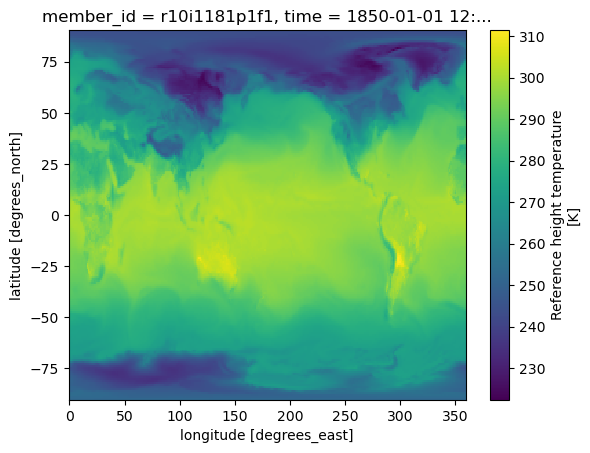

In [17]:
%%time
test_zarr.isel(member_id=0,time=0).plot()

In [12]:
%%time
#Using HTTPS protocol
# test = xr.open_dataset('https://osdf-director.osg-htc.org/aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr',\
#                       engine='zarr').TREFHT
#Using pelicanfs' OSDF protocol
test = xr.open_dataset('osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr',\
                       engine='zarr').TREFHT
test

CPU times: user 102 ms, sys: 2.22 ms, total: 104 ms
Wall time: 347 ms


<xarray.DataArray 'TREFHT' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
[166510080000 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [13]:
# %%time
# test.values

# Comments
- PelicanFs doesn't seem to support the 'ls' command
- However, we can load the zarr store using the full url/ pelfs 
- So, let us try using an intake catalog
- The original intake catalog can be found at 'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
- Let us modify this catalog, by pre-pending the s3 path to the object ncar-cesm2-lens with the osdf-director + namespace
- The size of this catalog is > 100 MB. So, let us not upload it to a github repo
- Let us save the catalog to a folder on NCAR's disk storage

## Modify the intake catalog

In [14]:
# Open collection description file using intake
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)
catalog

,unique
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20
start_time,4


In [15]:
# df_s3 = catalog.df
# df_s3['path']

In [16]:
# # Change s3 paths to osdf paths
# df_s3['path'] = df_s3['path'].str.replace(s3_link, '')
# df_s3['path'] = osdf_url + df_s3['path'] 
# df_s3['path'].head().values

In [17]:
# %%time
# df_s3.to_csv(new_intake_csvpath)

## Test the new intake catalog after spinning up a cluster

In [18]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '5:00:00',
    log_directory = rda_scratch+'/dask/logs',
    #interface = 'ib0'
    interface = 'ext'
)

In [19]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.95:41861,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [20]:
cluster.scale(4)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.95:41861,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Access the data from the AWS bucket using intake to compare

In [21]:
osdf_catalog = intake.open_esm_datastore(
   new_intake_url 
)
osdf_catalog

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [22]:
osdf_catalog.df['path'].head().values

array(['osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [23]:
osdf_catalog_temp = osdf_catalog.search(variable ='TREFHTMX', frequency ='daily')
osdf_catalog_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [24]:
%%time
#dsets = osdf_catalog_temp.to_dataset_dict(storage_options={'anon':True})
dsets = osdf_catalog_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


CPU times: user 1.66 s, sys: 450 ms, total: 2.11 s
Wall time: 1min 34s


In [25]:
%%time
dsets.keys()

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.01 μs


dict_keys(['atm.historical.daily.cmip6', 'atm.historical.daily.smbb', 'atm.ssp370.daily.cmip6', 'atm.ssp370.daily.smbb'])

In [26]:
historical_smbb = dsets['atm.historical.daily.smbb']
historical_smbb

<xarray.Dataset> Size: 666GB
Dimensions:    (member_id: 50, time: 60225, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, nbnd) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHTMX   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...
    ...                                ...
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:path:             osdf:///aws-opendata/us-west-2/ncar-ce...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.daily.smbb

In [27]:
%%time
historical_smbb.TREFHTMX.isel(member_id=0,time=0)

CPU times: user 860 μs, sys: 0 ns, total: 860 μs
Wall time: 866 μs


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288)> Size: 221kB
dask.array<getitem, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1191p1f2'
    time       object 8B 1850-01-01 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

CPU times: user 154 ms, sys: 40.6 ms, total: 194 ms
Wall time: 8.17 s


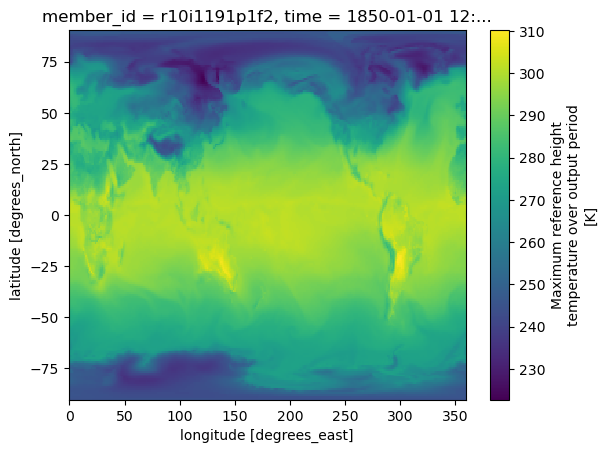

In [28]:
%%time
historical_smbb.TREFHTMX.isel(member_id=0,time=0).plot()

In [29]:
%%time
historical_smbb.TREFHTMX.isel(member_id=0,time=0).values

CPU times: user 4.14 s, sys: 1.56 s, total: 5.7 s
Wall time: 5min 2s


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [30]:
historical_smbb_init = historical_smbb.TREFHTMX.sel(time=slice(init_year0, init_year1))
historical_smbb_init

<xarray.DataArray 'TREFHTMX' (member_id: 50, time: 8760, lat: 192, lon: 288)> Size: 97GB
dask.array<getitem, shape=(50, 8760, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
  * time       (time) object 70kB 1991-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

## Data Access Speed tests
- We will now test how long it takes to access data (via OSDF) for various sizes using one of the above arrays

In [31]:
# Test 0 : Single data point, Mem: 4 bytes. Takes 1 min 30s when .compute() is called on this data array (which loads data into memory)
historical_smbb_init0 = historical_smbb_init.isel(lat=0,lon=0,time=0,member_id=0)

In [32]:
#Test 1: Whole globe +all member_ids for 1 time step, Mem: 10.55 MiB ~ 10.55 MB
historical_smbb_init1 = historical_smbb_init.isel(time=0)
historical_smbb_init1

<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(50, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1991-01-01 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [33]:
#Try using a specific cache
sdsc_cache='https://sdsc-cache.nationalresearchplatform.org:8443/aws-opendata/us-west-2/ncar-cesm2-lens/atm/monthly/'+\
            'cesm2LE-historical-smbb-TREFHTMX.zarr'

In [34]:
%%time
test_1 = xr.open_zarr(sdsc_cache).TREFHTMX.isel(time=0)
test_1

CPU times: user 27.5 ms, sys: 8.92 ms, total: 36.4 ms
Wall time: 704 ms


<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(50, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1850-01-16 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [35]:
%%time
test_1.compute()

CPU times: user 286 ms, sys: 84.3 ms, total: 370 ms
Wall time: 14.3 s


<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
array([[[249.19678, 249.19678, 249.19678, ..., 249.19678, 249.19678,
         249.19678],
        [250.43887, 250.38249, 250.20448, ..., 250.51567, 250.49054,
         250.4645 ],
        [251.08882, 251.02448, 250.98175, ..., 251.38719, 251.31668,
         251.22348],
        ...,
        [252.86601, 252.86296, 252.86362, ..., 252.86687, 252.86418,
         252.86697],
        [253.20384, 253.19318, 253.18105, ..., 253.23492, 253.22736,
         253.21567],
        [253.72546, 253.72377, 253.72223, ..., 253.73227, 253.72937,
         253.72731]],

       [[250.03368, 250.03374, 250.03377, ..., 250.03348, 250.03358,
         250.03354],
        [251.50316, 251.46185, 251.30855, ..., 251.60414, 251.58113,
         251.54517],
        [251.80588, 251.75319, 251.708  , ..., 252.13205, 252.05107,
         251.94751],
...
        [268.4083 , 268.4154 , 268.42007, ..., 268.38837, 268.39636,
         268.4018 ],
        [267.8907 , 267.89398, 267.91336, ..., 267.87415, 267.8794 ,
         267.88562],
        [267.46216, 267.46402, 267.46616, ..., 267.4559 , 267.4582 ,
         267.46027]],

       [[251.26021, 251.26021, 251.26021, ..., 251.26021, 251.26021,
         251.26021],
        [252.20267, 252.15547, 251.99138, ..., 252.24664, 252.23686,
         252.22755],
        [252.2071 , 252.15166, 252.12477, ..., 252.44124, 252.40294,
         252.3248 ],
        ...,
        [255.79259, 255.81528, 255.84357, ..., 255.7705 , 255.77013,
         255.77153],
        [257.0061 , 257.0269 , 257.04892, ..., 256.95438, 256.97034,
         256.98737],
        [258.37668, 258.3746 , 258.3727 , ..., 258.38428, 258.38147,
         258.37894]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1850-01-16 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [36]:
%%time
# Now, try to access the same array without specifying the cache
historical_smbb_init1.compute()

CPU times: user 4.43 s, sys: 1.35 s, total: 5.79 s
Wall time: 5min 3s


<xarray.DataArray 'TREFHTMX' (member_id: 50, lat: 192, lon: 288)> Size: 11MB
array([[[253.07646, 253.07645, 253.07706, ..., 253.07654, 253.07657,
         253.07657],
        [253.71193, 253.63765, 253.45703, ..., 253.78955, 253.76532,
         253.74123],
        [254.10101, 254.02785, 253.99356, ..., 254.39798, 254.32722,
         254.24188],
        ...,
        [248.08328, 248.24896, 248.39168, ..., 247.68118, 247.80733,
         247.92326],
        [245.76472, 245.73828, 245.7107 , ..., 245.83868, 245.81258,
         245.78906],
        [244.19325, 244.19902, 244.20427, ..., 244.17209, 244.17987,
         244.18689]],

       [[247.64154, 247.64156, 247.64156, ..., 247.64154, 247.64154,
         247.64154],
        [246.0501 , 245.99698, 245.83105, ..., 246.11678, 246.1007 ,
         246.07565],
        [246.06451, 246.03659, 246.0119 , ..., 246.41399, 246.33171,
         246.24179],
...
        [245.82777, 245.85257, 245.87422, ..., 245.77992, 245.79184,
         245.80444],
        [246.03772, 246.046  , 246.05515, ..., 246.02188, 246.025  ,
         246.03061],
        [246.76054, 246.7583 , 246.75626, ..., 246.7688 , 246.76576,
         246.76303]],

       [[246.54584, 246.54584, 246.54584, ..., 246.54584, 246.54584,
         246.54584],
        [247.47964, 247.43958, 247.28362, ..., 247.5261 , 247.51445,
         247.50308],
        [248.44585, 248.43582, 248.38974, ..., 248.62247, 248.58575,
         248.51422],
        ...,
        [268.36813, 268.33102, 268.29535, ..., 268.49606, 268.4552 ,
         268.41144],
        [267.49887, 267.4712 , 267.44   , ..., 267.57486, 267.54895,
         267.5248 ],
        [266.697  , 266.6997 , 266.70215, ..., 266.68713, 266.69077,
         266.69403]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
    time       object 8B 1991-01-01 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [ ]:
# Load the same object via the NCAR origin
ncar_glade_test = xr.open_zarr('osdf:///ncar/rda-transfer/chifan_AWS/ncar-cesm2-lens/atm/monthly/cesm2LE-historical-smbb-TREFHTMX.zarr').TREFHTMX.isel(time=0)
ncar_glade_test

In [ ]:
%%time
ncar_glade_test.compute()